In [1]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import pandas as pd
import seq_generator
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import json
from keras.preprocessing import image
import matplotlib.pyplot as plt
from train_cnn_base import get_ds


df = pd.read_feather("new_train_imgs.df").set_index("key")
train_df = df.loc[df.ds_type=="train"]
val_df = df.loc[df.ds_type=="val"].copy()
val_ds = get_ds(val_df,128)
model = tf.keras.models.load_model("../../view_directions_task_single_image/Training/training_results/last_model/Seqs_New_TrainB0_All/model")
model.load_weights("../../view_directions_task_single_image/Training/training_results/weights/Seqs_New_TrainB0_All/cp.ckpt")

c:\Users\ual\.conda\envs\felix\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df.value_counts('view_direction')

view_direction
Sideways    40838
Forward     40426
Backward      606
dtype: int64

In [3]:
preds = model.predict(val_ds,verbose = 1) > 0.5

130/130 [==============================] - 13s 67ms/step


In [4]:
model.evaluate(val_ds)

130/130 [==============================] - 10s 69ms/step - loss: 0.1840 - accuracy: 0.9313


[0.18402065336704254, 0.9313452839851379]

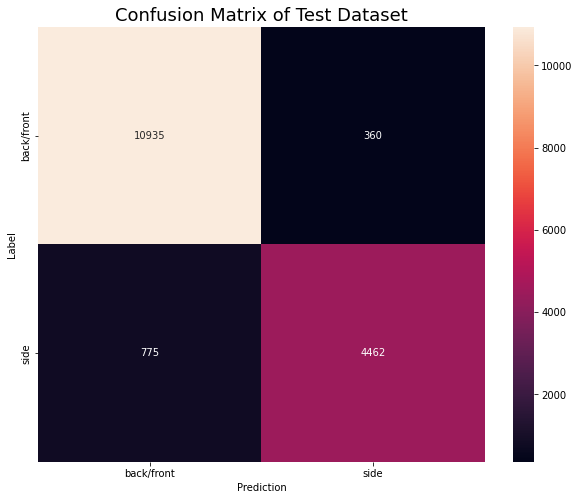

In [5]:
labels = np.concatenate([i[1] for i in tfds.as_numpy(val_ds)])
confusion_mtx = tf.math.confusion_matrix(labels,preds.reshape(-1))
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

names = ["back/front","side"]

sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
plt.title("Confusion Matrix of Test Dataset",fontsize=18)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [6]:
rawpreds = model.predict(val_ds,verbose = 1) 
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
val_df["loss"] = bce(labels[:,None].astype(float),rawpreds)

130/130 [==============================] - 9s 68ms/step


In [7]:
#val_df.sort_values("loss",ascending=False,inplace=True)

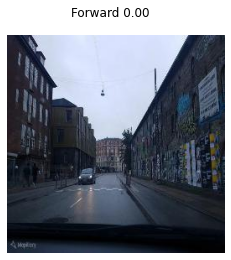

In [8]:
def plot_row(row):
    
    keys = row['local_path']
    plt.imshow(plt.imread(keys))
    plt.axis('off')
    plt.suptitle(f"{row['view_direction']} {row['loss'] :.2f}")
    plt.show()

plot_row(val_df.iloc[0])

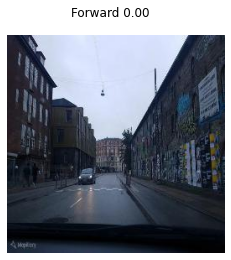

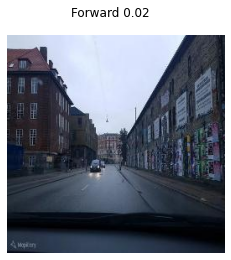

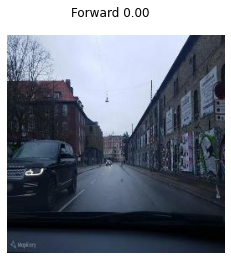

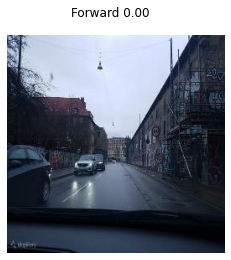

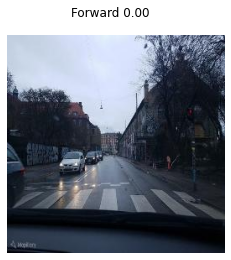

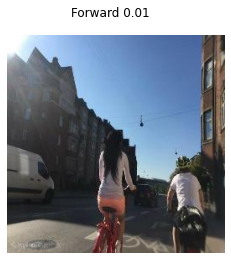

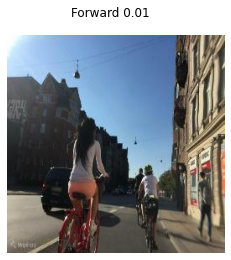

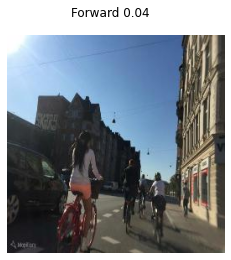

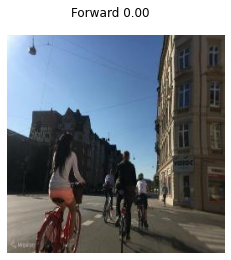

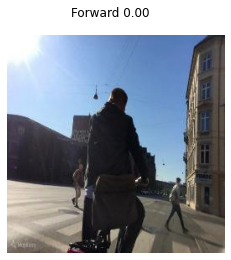

[None, None, None, None, None, None, None, None, None, None]

In [9]:
[plot_row(val_df.iloc[i]) for i in range(10)]

In [10]:
# (5 < val_df.loss).sum()
# df = val_df

# high_loss = df[(5 < df.loss) ]
# import tqdm
# for n in tqdm.tqdm(range(len(high_loss))):

#     row = high_loss.iloc[n]
#     keys = row['local_path']

#     plt.imshow(plt.imread(keys))
#     plt.axis("off")
#     plt.suptitle(f"{row['view_direction']} {row['loss'] :.2f}")
#     path = "tmp/new_train_hl/" +  str(high_loss.index[n]) + ".jpg"
#     plt.savefig(path)
#     plt.close()

In [11]:
seqs = pd.read_feather('new_train_seqs.df').set_index('index')
seqs = seqs.loc[seqs.ds_type == 'val']

In [12]:
seqs["loss"] = seqs["keys"].apply(lambda x: val_df.loc[x,"loss"].mean() if not any(i in x for i in ['ukil4wg0n8w_QIGi400gxA','RB9Ct26fCsjfGU696kOhYg', 'OAVb43zRFzezU6GpDTRiXA', '9goIHboMVZkFaeCK1rrmRA'])  else pd.NA)

In [13]:
#seqs.sort_values('loss',ascending=False,inplace=True)

In [14]:
func = lambda s: s[s.find("images/")+7:]
seqs["local_path"] = np.array([[f"../seq_data/{s}/{func(i)}"for i in c] for c,s in zip(seqs.Paths,seqs.ds_type)]).tolist()

In [15]:
# high_loss = seqs[(2 < seqs.loss) ]

# for n in tqdm.tqdm(range(len(high_loss))):

#     row = high_loss.iloc[n]
#     fig, ax = plt.subplots(2,2,figsize=(12,12))
#     keys = row['local_path']
#     #np.random.shuffle(keys)
#     for i,a in enumerate(ax.flatten()):
#         try:
#             a.imshow(plt.imread(keys[i]))
#         except: pass
#         a.axis('off')
#     plt.suptitle(f"{row['view_direction']} {row['loss'] :.2f}")
#     path = "tmp/new_train_seqs/" +  str(high_loss.index[n]) + ".jpg"
#     plt.savefig(path)
#     plt.close()

In [16]:
# seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/front/')], 'view_direction'] = 'Forward'
# seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/side/')], 'view_direction'] = 'Sideways'
# val_df.loc[np.unique(np.concatenate(seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/front/')],"keys"].values)),"view_direction"] = "Forward"
# val_df.loc[np.unique(np.concatenate(seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/side/')],"keys"].values)),"view_direction"] = "Sideways"

# val_df.drop(index = np.unique(np.concatenate(seqs.loc[[int(i[:-4]) for i in os.listdir('tmp/del/')],"keys"].values)),inplace=True)
# seqs.drop(index = [int(i[:-4]) for i in os.listdir('tmp/del/')], inplace= True)
# og_seqs = pd.read_feather('new_train_seqs.df').set_index('index')
# og_seqs.loc[og_seqs.ds_type == 'val'] = seqs
# og_seqs.reset_index().to_feather('new_train_seqs.df')
# df.loc[df.ds_type == 'val'] = val_df
# df.reset_index().to_feather("new_train_imgs.df")

In [17]:
val_df['rawp'] = rawpreds

seqs['pred'] = seqs['keys'].apply(lambda x: val_df.loc[x,"rawp"].mean()  if not any(i in x for i in ['ukil4wg0n8w_QIGi400gxA','RB9Ct26fCsjfGU696kOhYg', 'OAVb43zRFzezU6GpDTRiXA', '9goIHboMVZkFaeCK1rrmRA'])  else pd.NA)

In [18]:
((val_df.rawp > 0.5) == (val_df.view_direction == 'Sideways')).mean()

0.9313452697798209

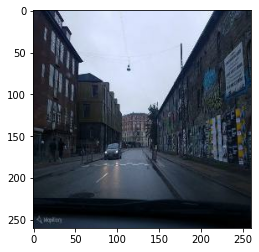

In [19]:
for i in tfds.as_numpy(val_ds.take(1)):
    plt.imshow(i[0][0])
    break

In [20]:
((seqs.view_direction == 'Sideways') == (seqs.pred > 0.5)).mean()

0.9295242329924411

In [24]:
model.layers[-3:]

In [25]:
cut = tf.keras.Model(model.input,model.layers[-3].output)

In [26]:
cut.save('cnn_base/model')

INFO:tensorflow:Assets written to: cnn_base/model\assets
